<a href="https://colab.research.google.com/github/wavhalkomal/AAI-551-A-Engineering-Programming-Python/blob/main/data2vec_vision_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll fine-tune a model pre-trained using data2vec. We'll leverage the `transformers` library for loading the pre-trained model and we'll then append a custom classification head for fine-tuning. For data handling we'll use `tf.data`.

Checkout the data2vec paper [here](https://arxiv.org/abs/2202.03555) and the model documentation page [here](https://huggingface.co/docs/transformers/main/en/model_doc/data2vec).

## Setup

In [18]:
# Otherwise TF's data2vec vision model won't be available.
# Date: May 06, 2022
!pip install git+https://github.com/huggingface/transformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from transformers import TFAutoModelForImageClassification, TFData2VecVisionModel
from transformers import create_optimizer

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Primary constants

In [20]:
# Model
IMAGE_SIZE = [224, 224]
MODEL_ID = "facebook/data2vec-vision-base"  # pre-trained model from which to fine-tune

# Data
BATCH_SIZE = 16  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

## Data related utilities

In [21]:
# Closely aligns with https://github.com/huggingface/transformers/blob/main/src/transformers/models/beit/feature_extraction_beit.py
# in regards to resizing and normalization.


def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    dataset = dataset.map(preprocess, AUTO).batch(BATCH_SIZE)
    # Transpose because the `transformers` model has a leading channel dimension.
    dataset = dataset.map(lambda x, y: (tf.transpose(x, [0, 3, 1, 2]), y), AUTO)
    return dataset.prefetch(AUTO)

## Load and visualize the `tf_flowers` dataset

In [22]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


In [23]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

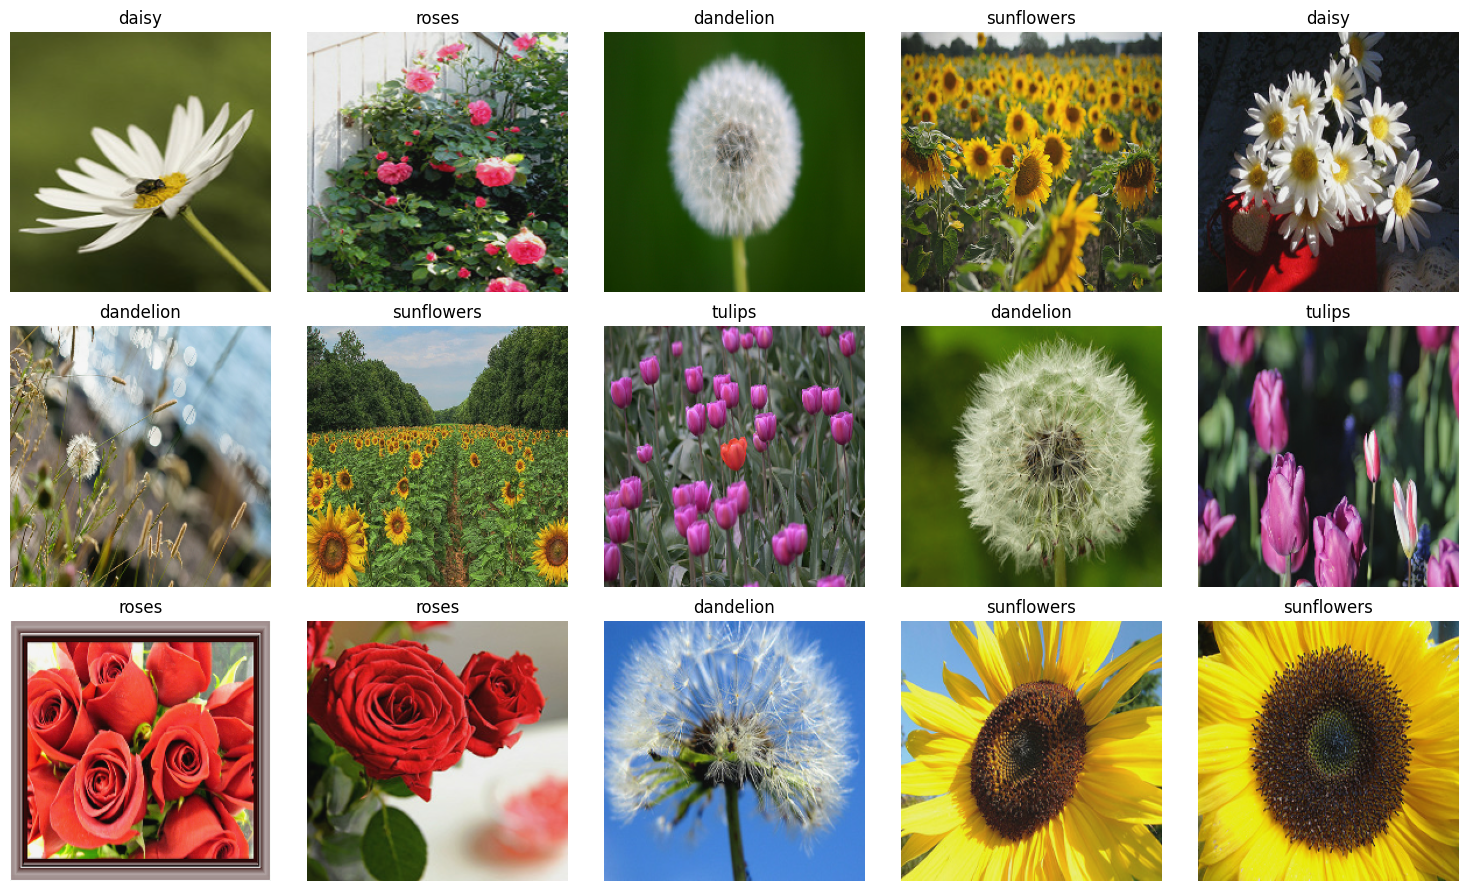

In [24]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n].numpy().transpose(1, 2, 0) * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Model building utilities

In [31]:
def get_model():
    base_model = TFData2VecVisionModel.from_pretrained(MODEL_ID)
    base_model.trainable = True

    inputs = layers.Input((3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
    x = base_model(inputs, training=False)
    outputs = layers.Dense(5)(x.last_hidden_state[:, 0])
    model = keras.Model(inputs, outputs)

    return model

model = get_model()

Some layers from the model checkpoint at facebook/data2vec-vision-base were not used when initializing TFData2VecVisionModel: ['classifier']
- This IS expected if you are initializing TFData2VecVisionModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFData2VecVisionModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFData2VecVisionModel were initialized from the model checkpoint at facebook/data2vec-vision-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFData2VecVisionModel for predictions without further training.


ValueError: Exception encountered when calling layer 'tf_data2_vec_vision_model_4' (type TFData2VecVisionModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'tf_data2_vec_vision_model_4' (type TFData2VecVisionModel):
  • pixel_values=<KerasTensor shape=(None, 3, 224, 224), dtype=float32, sparse=False, name=keras_tensor_4>
  • bool_masked_pos=None
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFData2VecVisionModel

def get_model():
    # Load the base model (e.g., from Hugging Face)
    base_model = TFData2VecVisionModel.from_pretrained(MODEL_ID)
    base_model.trainable = True

    # Define the input shape as (height, width, channels)
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  # 3 channels for RGB images

    # Wrap the inputs in a dictionary with 'pixel_values' as the key
    pixel_values = {'pixel_values': inputs}

    # Pass the input dictionary to the base model
    x = base_model(pixel_values, training=False)

    # Extract the output (assuming you want the first token [CLS] representation)
    x = x[0]  # The model output is usually a tuple, and x[0] holds the feature tensor

    # Add a Dense layer for classification (adjust the number of units as needed)
    outputs = layers.Dense(5)(x[:, 0])  # Assuming x[:, 0] is the [CLS] token

    # Create the final model
    model = keras.Model(inputs, outputs)

    return model

# Create the model
model = get_model()


Some layers from the model checkpoint at facebook/data2vec-vision-base were not used when initializing TFData2VecVisionModel: ['classifier']
- This IS expected if you are initializing TFData2VecVisionModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFData2VecVisionModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFData2VecVisionModel were initialized from the model checkpoint at facebook/data2vec-vision-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFData2VecVisionModel for predictions without further training.


ValueError: Exception encountered when calling layer 'tf_data2_vec_vision_model_8' (type TFData2VecVisionModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'tf_data2_vec_vision_model_8' (type TFData2VecVisionModel):
  • pixel_values={'pixel_values': '<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_8>'}
  • bool_masked_pos=None
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

In [26]:
model = get_model()
model.summary()

Some layers from the model checkpoint at facebook/data2vec-vision-base were not used when initializing TFData2VecVisionModel: ['classifier']
- This IS expected if you are initializing TFData2VecVisionModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFData2VecVisionModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFData2VecVisionModel were initialized from the model checkpoint at facebook/data2vec-vision-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFData2VecVisionModel for predictions without further training.


ValueError: Exception encountered when calling layer 'tf_data2_vec_vision_model_2' (type TFData2VecVisionModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for pixel_values.

Call arguments received by layer 'tf_data2_vec_vision_model_2' (type TFData2VecVisionModel):
  • pixel_values=<KerasTensor shape=(None, 3, 224, 224), dtype=float32, sparse=False, name=keras_tensor_2>
  • bool_masked_pos=None
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False

## Compile model and train it

In [15]:
num_train_epochs = 3
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0


num_train_steps = (num_train // BATCH_SIZE) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

In [14]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

NameError: name 'model' is not defined

In [12]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_train_epochs)

NameError: name 'model' is not defined

## Visualize training progress

In [13]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])

NameError: name 'history' is not defined

## References

* https://github.com/sayakpaul/cait-tf/blob/main/notebooks/finetune.ipynb
* https://colab.research.google.com/drive/1M4CEl6Jgf4KgqLHb4_bi3acJvNNLZqZd